# Двухуровневые модели рекомендаций

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(2375, N=5)

[1044078, 899624, 844179, 871756, 1106523]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 6552253, 15778319]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[963686, 1096573, 1012801, 820612, 1116635]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
K = 50
users_train = data_train_lvl_1['user_id'].tolist()
users_valid = result_lvl_1['user_id'].tolist()
new_users = list(set(users_valid) - set(users_train))
users_list = list(set(users_valid) & set(users_train))

cols = ['top_popular', 'als_recommendations', 
        'own_recommendations', 'similar_items_recommendation'
       ]
df = pd.DataFrame(index=users_valid, columns=cols)

overall_top_purchases = recommender.overall_top_purchases[:K]
for user in new_users:
    for col in cols:
        df.loc[user, col] = overall_top_purchases
        
for user in users_list:
    df.loc[user, 'top_popular'] = overall_top_purchases
    df.loc[user, 'als_recommendations'] = recommender.get_als_recommendations(user, K)
    df.loc[user, 'own_recommendations'] = recommender.get_own_recommendations(user, K)
    df.loc[user, 'similar_items_recommendation'] = recommender.get_similar_items_recommendation(user, K)    
   

        
df = df.reset_index()
df.columns = ['user_id'] + cols
result_lvl_1 = result_lvl_1.merge(df, on='user_id', how='left')

In [13]:
for col in cols:    
    recall = result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], K), axis=1).mean()
    print(f'recall_at_{K} {col}: {round(recall, 4)}')

recall_at_50 top_popular: 0.0432
recall_at_50 als_recommendations: 0.0467
recall_at_50 own_recommendations: 0.0652
recall_at_50 similar_items_recommendation: 0.0341


__own_recomendations__ - дает наилучший результат

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500} 

In [14]:
k = [20, 50, 100, 200, 500]
cols = ['own_recommendations_' + str(i) for i in k]
df = pd.DataFrame(index=users_valid, columns=cols)

for i, K in enumerate(k):
    overall_top_purchases = recommender.overall_top_purchases[:K]
    for user in new_users:        
        df.loc[user, cols[i]] = overall_top_purchases
        
    for user in users_list:
        df.loc[user, cols[i]] = recommender.get_own_recommendations(user, K)
        
df = df.reset_index()
df.columns = ['user_id'] + cols
result_lvl_1 = result_lvl_1.merge(df, on='user_id', how='left')

recall_at_500 own_recommendations_20: 0.0392
recall_at_500 own_recommendations_50: 0.0652
recall_at_500 own_recommendations_100: 0.096
recall_at_500 own_recommendations_200: 0.1353
recall_at_500 own_recommendations_500: 0.1819


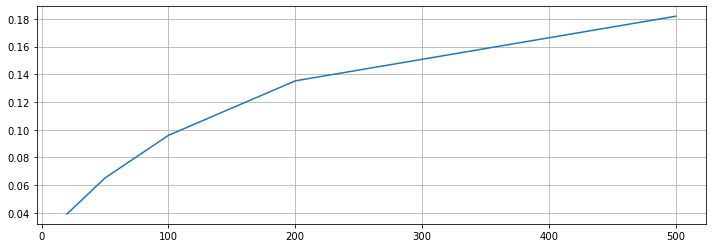

In [17]:
rec_list = []

for i, K in enumerate(k):   
    recall = result_lvl_1.apply(lambda row: recall_at_k(row[cols[i]], row['actual'], K), axis=1).mean()
    print(f'recall_at_{N} {cols[i]}: {round(recall, 4)}')
    rec_list.append(recall)
    
plt.figure(figsize=(12, 4))
plt.plot(k, rec_list)
plt.grid(True) 

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

C увеличением k растет и recall@k, что позволяет модели делать прогнозы точнее, но чем больше k, тем дольше модель будет работать. На мой взгляд оптимальным будет k=200

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [18]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

#создание списков кандидатов на первом уровне
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))

#разворачивание списков в столбцы
df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values).astype('int64')})

In [19]:
#создание таргета на основе полученных на первом уровне кандидатов и совпадения их с валидационным датасетом для первого уровня
targets_lvl_2 = data_train_lvl_2.drop_duplicates(['user_id', 'item_id'])[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2['target'].mean()

0.030327289632728963

In [20]:
# заменим бренд СТМ на 1, остальное на 0
item_features['brand'] = item_features['brand'].map({'National': 0, 'Private': 1})

In [21]:
# Заменимм возраст по нижней границе
user_features['age_desc'] = user_features['age_desc'].map({
    '45-54': 45, '35-44': 35, '55-64': 55, '25-34': 25, '65+': 65, '19-24': 19
})

# Заменимм доход по нижней границе
user_features['income_desc'] = user_features['income_desc'].map({
    '50-74K': 50000, '35-49K': 35000, '75-99K': 75000, '25-34K': 25000, '15-24K': 15000, 'Under 15K': 0, 
    '125-149K': 125000, '100-124K': 100000, '150-174K': 150000, '250K+': 250000, '175-199K': 175, 
    '200-249K': 200000})
# Заменим в кол-ве детей 3+ на 3
user_features['kid_category_desc'] = user_features['kid_category_desc'].map({'None/Unknown': 0, '3+': 3})

# Заменим собственость на "вероятность владения домом"
user_features['homeowner_desc'] = user_features['homeowner_desc'].map({'Homeowner': 1, 'Unknown': 0, 'Renter': 0, 
                                    'Probable Owner': 0.75, 'Probable Renter': 0.25})
#  Заменим в размере дома 5+ на 5
user_features['household_size_desc'] = user_features['household_size_desc'].map({'5+': 5})

In [22]:
# Добавим средний чек
user_features = user_features.merge(right = user_features.merge(right=data, on='user_id', how='left') \
                                    .groupby(by='user_id')['sales_value'].mean() \
                                    .reset_index().rename(columns={'sales_value': 'average_purchase'}),
                                    on='user_id', how='left')

In [23]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [24]:
X_train = targets_lvl_2.drop(['user_id', 'item_id', 'target'], axis=1)
y_train = targets_lvl_2['target']

In [26]:
X_train.head()

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_purchase
0,69,DELI,1,SANDWICHES,SANDWICHES - (COLD),,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
1,2468,GROCERY,0,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
2,69,DRUG GM,1,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
3,1213,DRUG GM,0,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039
4,69,DRUG GM,1,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45.0,U,50000.0,0.0,Unknown,NaN,0.0,2.891039


In [27]:
# cat_feats = X_train.columns[1:].tolist()
cat_feats = ['department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'marital_status_code', 'hh_comp_desc']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [28]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['department', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'marital_status_code', 'hh_comp_desc'],
               max_depth=7, objective='binary')

In [29]:
train_preds = lgb.predict_proba(X_train)[:, 1]

In [30]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique() \
            .reset_index().rename(columns={'item_id': 'actual'})

In [31]:
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [32]:
temp_result = targets_lvl_2.loc[:, ['user_id', 'item_id']]

In [33]:
#добавление неотсортированных кандидатов
candidats = temp_result.groupby('user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(candidats, on=['user_id'], how='left').rename(columns={'item_id': 'own_recs'})

In [34]:
#добавление отсортированных по LGBMClassifier кандидатов
temp_result['train_preds'] = train_preds
temp_result.sort_values('train_preds', ascending=False, inplace=True)

top_candidats = temp_result.groupby(by='user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(right=top_candidats, on=['user_id'], how='left')
result_lvl_2 = result_lvl_2.rename(columns={'item_id': 'lgbm_recs'})

In [37]:
result_lvl_2.head()

,user_id,actual,own_recs,lgbm_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1082185, 8293439, 9655212, 1022254, 1029743, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN,NaN
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1082185, 1082185, 845208, 900802, 1126899, 11..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1082185, 1029743, 1070820, 1126899, 1106523, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[12808385, 981660, 939860, 7410201, 6463874, 8...","[1082185, 1044078, 1068719, 9333437, 1106523, ..."


In [38]:
result_lvl_2.loc[result_lvl_2['lgbm_recs'].isnull()]

,user_id,actual,own_recs,lgbm_recs
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN,NaN
37,48,"[857000, 890533, 960718, 971585, 979178, 99606...",NaN,NaN
46,60,"[15512234, 17105530]",NaN,NaN
56,73,"[1069003, 1071939, 1110764, 1130581, 829291, 8...",NaN,NaN
72,89,"[878910, 956995, 1055863, 9879409, 12781501]",NaN,NaN
...,...,...,...,...
1942,2373,"[853262, 859075, 873203, 883404, 908940, 10297...",NaN,NaN
1951,2383,"[973016, 10198378, 15512234, 17105530, 948953]",NaN,NaN
1962,2399,"[820582, 835098, 938700, 947858, 1013321, 1030...",NaN,NaN
2030,2487,"[862407, 1099089, 1135834, 5570383, 10344585, ...",NaN,NaN


In [39]:
result_lvl_2 = result_lvl_2.drop(np.where(result_lvl_2['lgbm_recs'].isnull())[0], axis=0)

In [40]:
result_lvl_2.head()

,user_id,actual,own_recs,lgbm_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1082185, 8293439, 9655212, 1022254, 1029743, ..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 995598, 923600, 1138596, 10...","[1082185, 1082185, 845208, 900802, 1126899, 11..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1082185, 1029743, 1070820, 1126899, 1106523, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[12808385, 981660, 939860, 7410201, 6463874, 8...","[1082185, 1044078, 1068719, 9333437, 1106523, ..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[872146, 918046, 9655676, 985622, 1056005, 801...","[1082185, 1126899, 1070820, 1106523, 1029743, ..."


In [41]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_recs'], row['actual']), axis=1).mean()

0.16469973890339207

Вывод: при использовании двухуровневой модели precision вырос